In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import math
import random
import numpy as np
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from bayes_opt import BayesianOptimization

%matplotlib notebook

print('cusa available: ', torch.cuda.is_available())

# use either cpu or gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
device = "cpu"


cusa available:  True
cuda:0


In [190]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import time
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR

In [17]:

# function 1 ::  SUM( x )
def f_1(x):
    return torch.FloatTensor([sum(x)]).to(device)

# function 2 ::  SUM(x^2)
def f_2(x):
    res = 0.0
    for xi in x:
        res += pow(xi, 2)
    return torch.FloatTensor([res]).to(device)

'''
a = [10*random.random() for _ in range(10)]
e = [[random.randint(0, 3) for _ in range(20)] for _ in range(10)]

# function 3 :: random polynomial w 20 monomials and max exponents of 3
def f_3(x):
    res = 0.0
    # a = [10*random.random() for _ in range(10)]
    # e = [[random.randint(0, 6) for _ in range(len(x))] for _ in range(10)]
    for ei, ai in zip(e, a):
        res += ai*sum([pow(xi, elem) for elem, xi in zip(ei, x)])
    return torch.FloatTensor([res]).to(device)
    
print('constants f3: ', a)
print('exponents f3: ', e)
'''

constants f3:  [3.546072142199519, 4.309112711491475, 9.426316328580116, 8.652027274382895, 7.819469206665119, 5.060527842807694, 3.819221708914917, 5.504296550387002, 2.8817407279915406, 5.432430890823997]
exponents f3:  [[3, 0, 2, 1, 3, 0, 2, 2, 1, 3, 0, 3, 2, 0, 2, 3, 2, 3, 1, 3], [2, 0, 0, 1, 2, 3, 1, 1, 0, 3, 3, 2, 1, 1, 3, 2, 1, 0, 1, 2], [3, 2, 3, 2, 1, 3, 2, 2, 1, 3, 2, 1, 2, 2, 0, 1, 0, 3, 3, 0], [2, 0, 3, 2, 2, 3, 1, 2, 3, 3, 0, 0, 2, 1, 0, 2, 0, 3, 3, 3], [1, 2, 0, 3, 0, 3, 2, 0, 3, 3, 1, 2, 2, 1, 2, 1, 2, 2, 3, 2], [0, 3, 3, 2, 1, 1, 2, 2, 3, 0, 2, 3, 0, 3, 3, 1, 2, 2, 0, 0], [2, 3, 2, 0, 3, 0, 2, 2, 1, 2, 1, 3, 0, 1, 0, 1, 2, 3, 1, 0], [1, 1, 3, 0, 3, 3, 1, 0, 3, 0, 3, 1, 2, 2, 0, 3, 1, 3, 2, 2], [0, 2, 1, 0, 3, 1, 1, 3, 3, 0, 3, 3, 3, 0, 0, 0, 0, 2, 2, 3], [1, 0, 3, 1, 0, 3, 1, 0, 0, 1, 2, 2, 1, 3, 3, 1, 1, 3, 3, 0]]


In [259]:
def f_3(x):
    res = 0.0
    for i, xi in enumerate(x):
        res += (len(x)-i)*pow(xi, i+1)
    return torch.FloatTensor([res]).to(device)

In [4]:
# AS architecture
class A_Net(nn.Module):

    def __init__(self, input_dim, mon_dim, out_dim, b1, b2):
        super(A_Net, self).__init__()
        # input should be of size input_size, output mon_size. trained weights=e_nm
        self.lin_hidden = nn.Linear(input_dim, mon_dim, bias=b1)
        self.lin_hidden.weight.data.uniform_(0.0, 1.0)
        # output lin layer, trained weights=a_m
        self.lin_output = nn.Linear(mon_dim, out_dim, bias=b2)
        # alternative weights: -1, 1
        self.lin_output.weight.data.uniform_(0.0, 1.0)

    def forward(self, x):
        return self.lin_output(torch.exp(self.lin_hidden(torch.log(x))))

In [206]:
# relu architecture
class Net(nn.Module):

    def __init__(self, input_dim, mon_dim, out_dim, b1, b2):
        super(Net, self).__init__()
        # input should be of size input_size, output mon_size. trained weights=e_nm
        self.lin_hidden = nn.Linear(input_dim, mon_dim, bias=b1)
        # self.lin_hidden.weight.data.uniform_(0.0, 1.0)
        # output lin layer, trained weights=a_m
        self.lin_output = nn.Linear(mon_dim, out_dim, bias=b2)
        # alternative weights: -1, 1
        # self.lin_output.weight.data.uniform_(0.0, 1.0)

    def forward(self, x):
        return self.lin_output(F.relu(self.lin_hidden(x)))

In [212]:
class Net_2(nn.Module):

    def __init__(self, input_dim, mon_dim, out_dim, b1, b2):
        super(Net_2, self).__init__()
        # input should be of size input_size, output mon_size. trained weights=e_nm
        self.lin_hidden_1 = nn.Linear(input_dim, mon_dim, bias=b1)
        self.d1 = nn.Dropout(0.3)
        # self.lin_hidden.weight.data.uniform_(0.0, 1.0)
        # output lin layer, trained weights=a_m
        self.lin_hidden_2 = nn.Linear(mon_dim, mon_dim, bias=b2)
        self.d2 = nn.Dropout(0.2)
        self.lin_output = nn.Linear(mon_dim, out_dim, bias=True)
        # alternative weights: -1, 1
        # self.lin_output.weight.data.uniform_(0.0, 1.0)

    def forward(self, x):
        return self.lin_output(self.d2(F.relu(self.lin_hidden_2(self.d1(F.relu(self.lin_hidden_1(x)))))))

In [25]:
def data_hist(sample):
    # %matplotlib notebook
    vals = [int(dat[0]) for dat in sample]  # for _, dat in train_data]
    plt.hist(vals)

(tensor([[4.7085e-01, 1.7167e+00, 1.3467e-01, 7.0953e-01, 6.8953e-01, 2.1240e+00,
         3.5300e-01, 4.3792e-01, 1.8212e+00, 1.6441e-01],
        [6.0316e-01, 1.8305e+00, 4.8628e-02, 1.0277e+00, 1.5813e+00, 4.0322e-01,
         1.2982e+00, 7.1214e-02, 6.9589e-01, 1.8183e-01],
        [2.8281e-01, 4.4089e-01, 5.2611e-01, 3.8941e-03, 7.9481e-01, 1.0074e+00,
         1.2425e+00, 1.3113e+00, 6.3023e-01, 2.2929e-01],
        [4.6749e-01, 7.5577e-01, 4.6397e-01, 2.7869e-01, 1.1244e+00, 1.1310e+00,
         1.5689e-01, 1.1477e+00, 1.1799e+00, 2.4840e+00],
        [8.6754e-01, 6.6278e-01, 1.6298e+00, 6.4678e-01, 1.5716e+00, 1.0903e+00,
         1.2968e+00, 1.4282e+00, 1.3399e+00, 4.9217e-01],
        [1.0518e+00, 9.2725e-01, 1.4669e-01, 1.2039e-01, 8.4499e-01, 1.2277e+00,
         4.4950e-01, 7.6828e-01, 1.2771e+00, 6.5801e-01],
        [1.4484e+00, 6.3998e-01, 4.4679e-01, 6.6634e-01, 1.9736e+00, 1.7244e+00,
         2.0798e+00, 5.1557e-01, 1.2515e+00, 6.7989e-01],
        [6.2519e-01, 2.337

<IPython.core.display.Javascript object>


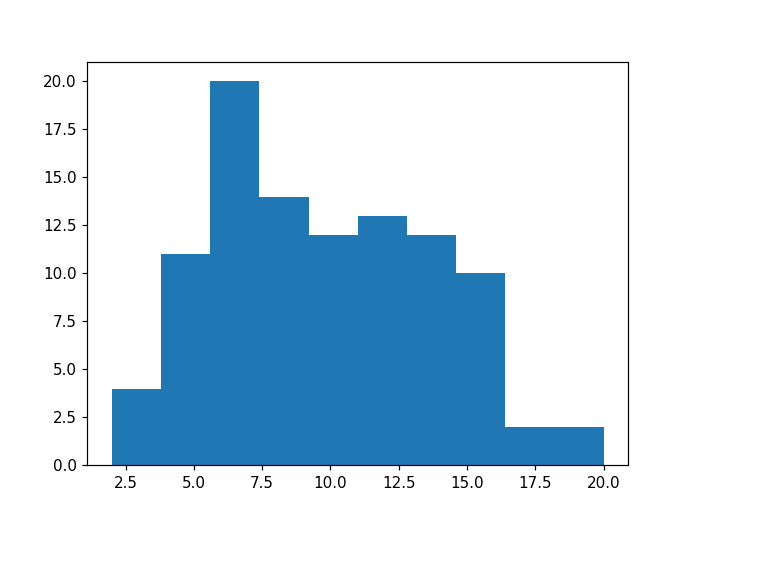

In [64]:
%matplotlib notebook

# generate synthetic dataset
# deal with negative values as sven
def make_data(n_samples, n_vars, func, scalar=1, mean=0, std=1):  # func=f_1
    X = []
    y = []
    for i in range(n_samples):
        x = torch.normal(mean, std, (n_vars,))
        while (x <= 0).any():
            x_new = torch.normal(mean, std, (n_vars,))
            x[x <= 0] = x_new[x <= 0]
        X.append(list(x))
        y.append([func(x)])
    return torch.FloatTensor(X).to(device), torch.FloatTensor(y).to(device)

dset = make_data(100, 10, f_2)
print(dset)
data_hist(dset[1])

In [214]:
inf = float('inf')

# do train test split
# define train and evaluate method
# cross validation
# training
# take method
# (self, input_dim, mon_dim, out_dim, b1, b2):
def train_and_test(X, y, nnet, mon_dim, b1, b2, bs, lr, momentum, max_epochs=1000, nsplits=5):
    # X, y = make_data(n, f_num)
    strt=time.time()
    input_dim = X.size(dim=1)
    kf = KFold(n_splits=nsplits)
    # loss list for every k fold
    k_loss = [[] for _ in range(nsplits)]
    val_loss = []
    for j, indices in enumerate(kf.split(X)):
        print('\n============= split '+str(j+1)+' =============\n')
        train_index, test_index = indices
        # print(type(train_index), type(test_index))
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        prev_loss = inf
        if nnet == 'poly':
            net = A_Net(input_dim, mon_dim, 1, b1, b2)
        elif nnet == '2':
            net = Net_2(input_dim, mon_dim, 1, b1, b2)
        else:
            net = Net(input_dim, mon_dim, 1, b1, b2)
        criterion = nn.MSELoss()
        optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
        training_data = DataLoader(list(zip(X_train, y_train)), batch_size=bs, shuffle=True)
        for epoch in range(max_epochs):  # loop over the dataset multiple times
            running_loss = 0.0
            for i, data in enumerate(training_data):
                # get the inputs; data is a list of [inputs, labels]
                inputs, result = data
                # print(inputs)
                # print(result)
                # break
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward + backward + optimize
                outputs = net(inputs)
                loss = criterion(outputs, result)
                loss.backward()
                # nn.utils.clip_grad_norm_(net.parameters(), max_norm=clip_norm)
                optimizer.step()
                # print statistics
                running_loss += loss.item()
            k_loss[j].append(running_loss/len(training_data))
            if epoch % 100 == 99:
                print('epoch: ', epoch+1, '; loss: ', running_loss/len(training_data))
            '''
            if running_loss > prev_loss:
                break
            prev_loss = running_loss
            '''
        # validation set
        out = net(X_test)
        loss = criterion(out, y_test)
        print('\nvalidation loss: ', loss.item())
        val_loss.append(loss.item())
    print('\n\n--------------\n\n')
    print('average loss: ', sum(val_loss)/nsplits)
    print('cross validation train and test took: '+str(time.time()-strt))
    return k_loss, val_loss
    


In [113]:
def train_and_test_linreg(X, y, nsplits=5):
    # X, y = make_data(n, f_num)
    input_dim = X.size(dim=1)
    kf = KFold(n_splits=nsplits)
    # loss list for every k fold
    val_loss = []
    for j, indices in enumerate(kf.split(X)):
        print('-- split: ', j+1)
        train_index, test_index = indices
        # print(type(train_index), type(test_index))
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        lr = LinearRegression()
        lr.fit(X_train, y_train)
        y_pred = lr.predict(X_test)
        loss = mean_squared_error(y_test, y_pred)
        val_loss.append(loss)
    print('average loss: ', sum(val_loss)/nsplits)
    return val_loss

In [264]:
def train_and_test_polyreg(X, y, deg=2, nsplits=5):
    # X, y = make_data(n, f_num)
    input_dim = X.size(dim=1)
    kf = KFold(n_splits=nsplits)
    # loss list for every k fold
    val_loss = []
    for j, indices in enumerate(kf.split(X)):
        print('-- split: ', j+1)
        train_index, test_index = indices
        # print(type(train_index), type(test_index))
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        poly = PolynomialFeatures(deg)
        X_new = poly.fit_transform(X_train)
        lr = LinearRegression()
        lr.fit(X_new, y_train)
        X_test_new = poly.transform(X_test)
        y_pred = lr.predict(X_test_new)
        loss = mean_squared_error(y_test, y_pred)
        val_loss.append(loss)
    print('average loss: ', sum(val_loss)/nsplits)
    return val_loss

In [203]:
def train_and_test_svr(X, y, nsplits=5, kernel='rbf'):
    # X, y = make_data(n, f_num)
    input_dim = X.size(dim=1)
    kf = KFold(n_splits=nsplits)
    # loss list for every k fold
    val_loss = []
    for j, indices in enumerate(kf.split(X)):
        print('-- split: ', j+1)
        train_index, test_index = indices
        # print(type(train_index), type(test_index))
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = np.ravel(y[train_index]), np.ravel(y[test_index])
        # svr = SVR(kernel='rbf', C=1.0, epsilon=0.2) # LinearRegression()
        svr = SVR(kernel=kernel, degree=2, C=1.0, epsilon=0.2)
        svr.fit(X_train, y_train)
        y_pred = svr.predict(X_test)
        loss = mean_squared_error(y_test, y_pred)
        val_loss.append(loss)
    print('average loss: ', sum(val_loss)/nsplits)
    return val_loss

In [260]:
# make_data(n_samples, n_vars, func, scalar=1, mean=1, std=0.5)
# X, y = make_data(20, 2, f_2)
X, y = make_data(100, 4, f_3)

<IPython.core.display.Javascript object>


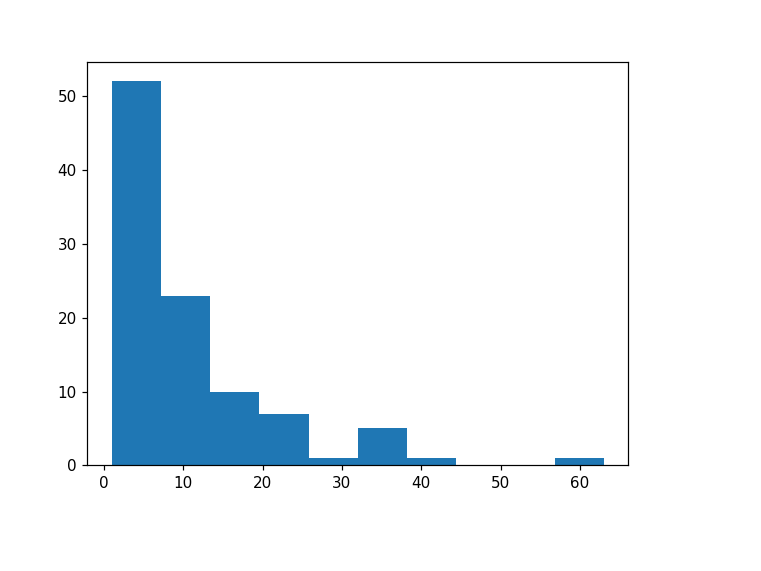

(array([52., 23., 10.,  7.,  1.,  5.,  1.,  0.,  0.,  1.]),
 array([ 1. ,  7.2, 13.4, 19.6, 25.8, 32. , 38.2, 44.4, 50.6, 56.8, 63. ]),
 <BarContainer object of 10 artists>)

In [262]:
%matplotlib notebook
vals = [int(dat[0]) for dat in y]  # for _, dat in train_data]
plt.hist(vals)

In [229]:
lr_v_loss = train_and_test_linreg(X, y, nsplits=5)

-- split:  1
-- split:  2
-- split:  3
-- split:  4
-- split:  5
average loss:  0.9583666861057282


In [249]:
lr_v_loss = train_and_test_polyreg(X, y, dim=12, nsplits=5)

-- split:  1
-- split:  2
-- split:  3
-- split:  4
-- split:  5
average loss:  121256.46009827945


In [232]:
lr_v_loss = train_and_test_svr(X, y, nsplits=5, kernel='rbf')

-- split:  1
-- split:  2
-- split:  3
-- split:  4
-- split:  5
average loss:  2.2988355858822103


In [263]:
# train_and_test(X, y, input_vars=20, monomials=24, bs=32, s=True, lr=0.004, m=0.8, max_epochs=160, clip_norm=2.0, nsplits=5)
poly_k_loss, poly_v_loss = train_and_test(X, y, nnet='poly', mon_dim=3, b1=False, b2=False, bs=4, lr=0.0001, momentum=0.8, max_epochs=1000, nsplits=5)
# k_l_bias, v_l_bias = train_and_test(X, y, mon_dim=2, b1=False, b2=True, bs=4, lr=0.0001, momentum=0.8, max_epochs=400, nsplits=5)


============= split 1 =============

epoch:  100 ; loss:  nan
epoch:  200 ; loss:  nan
epoch:  300 ; loss:  nan
epoch:  400 ; loss:  nan
epoch:  500 ; loss:  nan
epoch:  600 ; loss:  nan
epoch:  700 ; loss:  nan


KeyboardInterrupt: 

In [227]:
relu_k_loss, relu_v_loss = train_and_test(X, y, nnet='reg', mon_dim=5, b1=True, b2=True, bs=4, lr=0.0001, momentum=0.8, max_epochs=50000, nsplits=5)


============= split 1 =============

epoch:  100 ; loss:  1.9065164774656296
epoch:  200 ; loss:  1.3785668089985847
epoch:  300 ; loss:  1.0679996237158775
epoch:  400 ; loss:  0.8340180441737175
epoch:  500 ; loss:  0.6526390314102173
epoch:  600 ; loss:  0.5119293183088303
epoch:  700 ; loss:  0.40793943405151367
epoch:  800 ; loss:  0.33479907736182213
epoch:  900 ; loss:  0.28230205923318863
epoch:  1000 ; loss:  0.24368877615779638
epoch:  1100 ; loss:  0.21492024883627892
epoch:  1200 ; loss:  0.19291838631033897
epoch:  1300 ; loss:  0.1750445873476565
epoch:  1400 ; loss:  0.1611909307539463
epoch:  1500 ; loss:  0.14953530579805374
epoch:  1600 ; loss:  0.13910883478820324
epoch:  1700 ; loss:  0.1308330362662673
epoch:  1800 ; loss:  0.12339302618056536
epoch:  1900 ; loss:  0.11731255706399679
epoch:  2000 ; loss:  0.11198899708688259
epoch:  2100 ; loss:  0.10743891075253487
epoch:  2200 ; loss:  0.10421394370496273
epoch:  2300 ; loss:  0.10142503585666418
epoch:  2400 ;

epoch:  19300 ; loss:  0.015641775797121227
epoch:  19400 ; loss:  0.015537919476628304
epoch:  19500 ; loss:  0.015457181725651026
epoch:  19600 ; loss:  0.015359252109192312
epoch:  19700 ; loss:  0.015270730946213007
epoch:  19800 ; loss:  0.015198730863630772
epoch:  19900 ; loss:  0.015123699558898807
epoch:  20000 ; loss:  0.015075912233442068
epoch:  20100 ; loss:  0.014978336519561708
epoch:  20200 ; loss:  0.014933560509234667
epoch:  20300 ; loss:  0.014822352677583694
epoch:  20400 ; loss:  0.014738411409780383
epoch:  20500 ; loss:  0.01468506921082735
epoch:  20600 ; loss:  0.014566463534720242
epoch:  20700 ; loss:  0.014513264410197735
epoch:  20800 ; loss:  0.014420254388824105
epoch:  20900 ; loss:  0.014370895340107381
epoch:  21000 ; loss:  0.01429010322317481
epoch:  21100 ; loss:  0.014213531510904431
epoch:  21200 ; loss:  0.014172592549584806
epoch:  21300 ; loss:  0.014099076157435775
epoch:  21400 ; loss:  0.014034540392458439
epoch:  21500 ; loss:  0.013975413

epoch:  38000 ; loss:  0.009480613050982356
epoch:  38100 ; loss:  0.009437531232833862
epoch:  38200 ; loss:  0.009436265681870282
epoch:  38300 ; loss:  0.009418921603355557
epoch:  38400 ; loss:  0.00941990251885727
epoch:  38500 ; loss:  0.009412682731635869
epoch:  38600 ; loss:  0.009403439937159419
epoch:  38700 ; loss:  0.009433351340703666
epoch:  38800 ; loss:  0.009402740164659917
epoch:  38900 ; loss:  0.009391121857333928
epoch:  39000 ; loss:  0.0093883583904244
epoch:  39100 ; loss:  0.009379248891491443
epoch:  39200 ; loss:  0.009367859922349453
epoch:  39300 ; loss:  0.009362157201394439
epoch:  39400 ; loss:  0.009351278305985034
epoch:  39500 ; loss:  0.0093478033086285
epoch:  39600 ; loss:  0.009337699972093105
epoch:  39700 ; loss:  0.0093318308936432
epoch:  39800 ; loss:  0.009338101139292121
epoch:  39900 ; loss:  0.009323177859187126
epoch:  40000 ; loss:  0.009306423598900437
epoch:  40100 ; loss:  0.009309742948971689
epoch:  40200 ; loss:  0.00931037752889

epoch:  7000 ; loss:  0.02981726359575987
epoch:  7100 ; loss:  0.0289269732311368
epoch:  7200 ; loss:  0.02802481083199382
epoch:  7300 ; loss:  0.027232773136347532
epoch:  7400 ; loss:  0.02649194933474064
epoch:  7500 ; loss:  0.025771277956664562
epoch:  7600 ; loss:  0.025116257835179567
epoch:  7700 ; loss:  0.024524201755411923
epoch:  7800 ; loss:  0.023170340340584517
epoch:  7900 ; loss:  0.021802182542160153
epoch:  8000 ; loss:  0.02063943585380912
epoch:  8100 ; loss:  0.0196447242051363
epoch:  8200 ; loss:  0.018795824609696865
epoch:  8300 ; loss:  0.018087549600750208
epoch:  8400 ; loss:  0.017385280458256602
epoch:  8500 ; loss:  0.016781730577349663
epoch:  8600 ; loss:  0.01625427999533713
epoch:  8700 ; loss:  0.015776073443703353
epoch:  8800 ; loss:  0.015347137348726392
epoch:  8900 ; loss:  0.014951834455132484
epoch:  9000 ; loss:  0.014598560286685824
epoch:  9100 ; loss:  0.01428467663936317
epoch:  9200 ; loss:  0.014043365838006139
epoch:  9300 ; loss: 

epoch:  25800 ; loss:  0.011210028926143423
epoch:  25900 ; loss:  0.011209668300580233
epoch:  26000 ; loss:  0.01121031356160529
epoch:  26100 ; loss:  0.011197688698302954
epoch:  26200 ; loss:  0.011192240053787827
epoch:  26300 ; loss:  0.01118767901789397
epoch:  26400 ; loss:  0.011181828362168744
epoch:  26500 ; loss:  0.011188529373612255
epoch:  26600 ; loss:  0.01118351350305602
epoch:  26700 ; loss:  0.011173513194080442
epoch:  26800 ; loss:  0.011173637642059475
epoch:  26900 ; loss:  0.011180675573996268
epoch:  27000 ; loss:  0.011168585973791778
epoch:  27100 ; loss:  0.011170696030603722
epoch:  27200 ; loss:  0.011156181804835796
epoch:  27300 ; loss:  0.01115245174150914
epoch:  27400 ; loss:  0.011156097112689167
epoch:  27500 ; loss:  0.011167964607011527
epoch:  27600 ; loss:  0.011154450476169586
epoch:  27700 ; loss:  0.01113905297825113
epoch:  27800 ; loss:  0.011133996362332255
epoch:  27900 ; loss:  0.011153072933666408
epoch:  28000 ; loss:  0.011143316864

epoch:  44700 ; loss:  0.010723468381911516
epoch:  44800 ; loss:  0.010719454498030245
epoch:  44900 ; loss:  0.010718081233790144
epoch:  45000 ; loss:  0.010706889035645872
epoch:  45100 ; loss:  0.010707186069339514
epoch:  45200 ; loss:  0.010709505004342645
epoch:  45300 ; loss:  0.01070654287468642
epoch:  45400 ; loss:  0.010701273356971797
epoch:  45500 ; loss:  0.010703106061555445
epoch:  45600 ; loss:  0.010701969440560788
epoch:  45700 ; loss:  0.010694850498111919
epoch:  45800 ; loss:  0.01069898548303172
epoch:  45900 ; loss:  0.010689598449971527
epoch:  46000 ; loss:  0.010695191158447415
epoch:  46100 ; loss:  0.010687324291211553
epoch:  46200 ; loss:  0.010687692818464711
epoch:  46300 ; loss:  0.010686092980904505
epoch:  46400 ; loss:  0.010682603169698268
epoch:  46500 ; loss:  0.010683356042136438
epoch:  46600 ; loss:  0.010684341978048906
epoch:  46700 ; loss:  0.01067756224074401
epoch:  46800 ; loss:  0.010671359079424292
epoch:  46900 ; loss:  0.0106738243

epoch:  13800 ; loss:  0.039825419429689646
epoch:  13900 ; loss:  0.03979343129321933
epoch:  14000 ; loss:  0.039793976582586765
epoch:  14100 ; loss:  0.03979351790621877
epoch:  14200 ; loss:  0.03981507173739374
epoch:  14300 ; loss:  0.03979061543941498
epoch:  14400 ; loss:  0.039811965252738446
epoch:  14500 ; loss:  0.039842223981395364
epoch:  14600 ; loss:  0.03981173096690327
epoch:  14700 ; loss:  0.039759901468642056
epoch:  14800 ; loss:  0.03978754905983806
epoch:  14900 ; loss:  0.039809366688132286
epoch:  15000 ; loss:  0.03979143709875643
epoch:  15100 ; loss:  0.03980114997830242
epoch:  15200 ; loss:  0.03977661964017898
epoch:  15300 ; loss:  0.039770964067429304
epoch:  15400 ; loss:  0.039745676796883345
epoch:  15500 ; loss:  0.03972202481236309
epoch:  15600 ; loss:  0.039781819097697735
epoch:  15700 ; loss:  0.039731215219944715
epoch:  15800 ; loss:  0.03974612010642886
epoch:  15900 ; loss:  0.03976047714240849
epoch:  16000 ; loss:  0.03971535502932966
e

epoch:  32800 ; loss:  0.03954187175258994
epoch:  32900 ; loss:  0.03944962495006621
epoch:  33000 ; loss:  0.039435067446902394
epoch:  33100 ; loss:  0.039468853967264295
epoch:  33200 ; loss:  0.03945574117824435
epoch:  33300 ; loss:  0.0394916906952858
epoch:  33400 ; loss:  0.039441914181225
epoch:  33500 ; loss:  0.03946335660293698
epoch:  33600 ; loss:  0.039441828383132815
epoch:  33700 ; loss:  0.03943774139042944
epoch:  33800 ; loss:  0.03944474901072681
epoch:  33900 ; loss:  0.03947896440513432
epoch:  34000 ; loss:  0.03941968170693144
epoch:  34100 ; loss:  0.03943694749614224
epoch:  34200 ; loss:  0.039473935205023736
epoch:  34300 ; loss:  0.03942485747393221
epoch:  34400 ; loss:  0.03941423029755242
epoch:  34500 ; loss:  0.03942931431811303
epoch:  34600 ; loss:  0.03943365067243576
epoch:  34700 ; loss:  0.03950543992687017
epoch:  34800 ; loss:  0.03941029025008902
epoch:  34900 ; loss:  0.03943023725878447
epoch:  35000 ; loss:  0.03942932980135083
epoch:  35

epoch:  1800 ; loss:  0.12875927053391933
epoch:  1900 ; loss:  0.12024498451501131
epoch:  2000 ; loss:  0.11333476565778255
epoch:  2100 ; loss:  0.10706750303506851
epoch:  2200 ; loss:  0.1016050074249506
epoch:  2300 ; loss:  0.0960902413353324
epoch:  2400 ; loss:  0.0908280173316598
epoch:  2500 ; loss:  0.08637774363160133
epoch:  2600 ; loss:  0.08213669434189796
epoch:  2700 ; loss:  0.07834823057055473
epoch:  2800 ; loss:  0.07469165581278503
epoch:  2900 ; loss:  0.07135182712227106
epoch:  3000 ; loss:  0.0684577152132988
epoch:  3100 ; loss:  0.06533665442839265
epoch:  3200 ; loss:  0.062342357356101274
epoch:  3300 ; loss:  0.05990855302661657
epoch:  3400 ; loss:  0.057397416327148676
epoch:  3500 ; loss:  0.055358669720590115
epoch:  3600 ; loss:  0.053265768103301525
epoch:  3700 ; loss:  0.05140375392511487
epoch:  3800 ; loss:  0.04990143096074462
epoch:  3900 ; loss:  0.048256146255880594
epoch:  4000 ; loss:  0.046930610202252865
epoch:  4100 ; loss:  0.04570193

epoch:  20900 ; loss:  0.028250949922949076
epoch:  21000 ; loss:  0.028227059287019074
epoch:  21100 ; loss:  0.02826732664834708
epoch:  21200 ; loss:  0.02823397272732109
epoch:  21300 ; loss:  0.02823445198009722
epoch:  21400 ; loss:  0.028349740314297378
epoch:  21500 ; loss:  0.028344660066068172
epoch:  21600 ; loss:  0.028286130698688794
epoch:  21700 ; loss:  0.028228185139596462
epoch:  21800 ; loss:  0.028427831130102277
epoch:  21900 ; loss:  0.028266155626624823
epoch:  22000 ; loss:  0.02823074976913631
epoch:  22100 ; loss:  0.02825139951892197
epoch:  22200 ; loss:  0.028223303437698632
epoch:  22300 ; loss:  0.028340959222987294
epoch:  22400 ; loss:  0.02834307204466313
epoch:  22500 ; loss:  0.028287967201322317
epoch:  22600 ; loss:  0.0283450213028118
epoch:  22700 ; loss:  0.028230793308466673
epoch:  22800 ; loss:  0.028312047143117525
epoch:  22900 ; loss:  0.028470771852880716
epoch:  23000 ; loss:  0.028303456725552678
epoch:  23100 ; loss:  0.028251905925571

epoch:  39700 ; loss:  0.028271022019907832
epoch:  39800 ; loss:  0.028301664046011865
epoch:  39900 ; loss:  0.028271691408008337
epoch:  40000 ; loss:  0.028257613768801093
epoch:  40100 ; loss:  0.02823161859123502
epoch:  40200 ; loss:  0.028251802315935493
epoch:  40300 ; loss:  0.02826358866877854
epoch:  40400 ; loss:  0.028268152847886086
epoch:  40500 ; loss:  0.028223176836036146
epoch:  40600 ; loss:  0.02827842114493251
epoch:  40700 ; loss:  0.028225802001543343
epoch:  40800 ; loss:  0.028347207233309746
epoch:  40900 ; loss:  0.028244008193723857
epoch:  41000 ; loss:  0.028237331425771117
epoch:  41100 ; loss:  0.028299607103690505
epoch:  41200 ; loss:  0.028238782193511724
epoch:  41300 ; loss:  0.028369782958179712
epoch:  41400 ; loss:  0.028299863450229168
epoch:  41500 ; loss:  0.028279552003368735
epoch:  41600 ; loss:  0.028378140414133668
epoch:  41700 ; loss:  0.028349433792755008
epoch:  41800 ; loss:  0.028294344308960717
epoch:  41900 ; loss:  0.0282756963

epoch:  8800 ; loss:  0.0434654182754457
epoch:  8900 ; loss:  0.04260448133572936
epoch:  9000 ; loss:  0.04205750674009323
epoch:  9100 ; loss:  0.041410382371395826
epoch:  9200 ; loss:  0.040865917224437
epoch:  9300 ; loss:  0.040468276711180806
epoch:  9400 ; loss:  0.03996426588855684
epoch:  9500 ; loss:  0.039158360566943884
epoch:  9600 ; loss:  0.038579370360821486
epoch:  9700 ; loss:  0.03807489247992635
epoch:  9800 ; loss:  0.0376438950188458
epoch:  9900 ; loss:  0.037450677482411265
epoch:  10000 ; loss:  0.03713212953880429
epoch:  10100 ; loss:  0.036844322457909584
epoch:  10200 ; loss:  0.036849051248282194
epoch:  10300 ; loss:  0.03656466747634113
epoch:  10400 ; loss:  0.03650184255093336
epoch:  10500 ; loss:  0.036259228363633156
epoch:  10600 ; loss:  0.03630173369310796
epoch:  10700 ; loss:  0.03621972259134054
epoch:  10800 ; loss:  0.0360105917789042
epoch:  10900 ; loss:  0.03592317982111126
epoch:  11000 ; loss:  0.035953507758677006
epoch:  11100 ; los

epoch:  27900 ; loss:  0.034984471974894404
epoch:  28000 ; loss:  0.034936100943014026
epoch:  28100 ; loss:  0.03505018260329962
epoch:  28200 ; loss:  0.034868279937654734
epoch:  28300 ; loss:  0.03494718810543418
epoch:  28400 ; loss:  0.03501222585327923
epoch:  28500 ; loss:  0.03492272621951997
epoch:  28600 ; loss:  0.034947412787005305
epoch:  28700 ; loss:  0.03485365677624941
epoch:  28800 ; loss:  0.03489336813800037
epoch:  28900 ; loss:  0.03491842653602362
epoch:  29000 ; loss:  0.035057879285886884
epoch:  29100 ; loss:  0.03499349392950535
epoch:  29200 ; loss:  0.03483546571806073
epoch:  29300 ; loss:  0.03490733355283737
epoch:  29400 ; loss:  0.03487276844680309
epoch:  29500 ; loss:  0.03489729482680559
epoch:  29600 ; loss:  0.0348159926943481
epoch:  29700 ; loss:  0.03487171791493893
epoch:  29800 ; loss:  0.03483238071203232
epoch:  29900 ; loss:  0.03480846947059035
epoch:  30000 ; loss:  0.0349823459982872
epoch:  30100 ; loss:  0.034869959112256765
epoch: 

epoch:  46900 ; loss:  0.03437363542616367
epoch:  47000 ; loss:  0.034261107444763184
epoch:  47100 ; loss:  0.03420270385686308
epoch:  47200 ; loss:  0.03422058734577149
epoch:  47300 ; loss:  0.03428481181617826
epoch:  47400 ; loss:  0.03424327168613672
epoch:  47500 ; loss:  0.03426054306328297
epoch:  47600 ; loss:  0.03421889152377844
epoch:  47700 ; loss:  0.03441954730078578
epoch:  47800 ; loss:  0.03419392183423042
epoch:  47900 ; loss:  0.03423260012641549
epoch:  48000 ; loss:  0.0342115571256727
epoch:  48100 ; loss:  0.03422024007886648
epoch:  48200 ; loss:  0.03419787797611207
epoch:  48300 ; loss:  0.034172830171883106
epoch:  48400 ; loss:  0.034222029615193605
epoch:  48500 ; loss:  0.03425306035205722
epoch:  48600 ; loss:  0.034164808224886656
epoch:  48700 ; loss:  0.034169083228334785
epoch:  48800 ; loss:  0.03416120004840195
epoch:  48900 ; loss:  0.034251253586262465
epoch:  49000 ; loss:  0.03414601995609701
epoch:  49100 ; loss:  0.03418252570554614
epoch:

In [235]:
relu_2_k_loss, relu_2_v_loss = train_and_test(X, y, nnet='2', mon_dim=5, b1=True, b2=True, bs=4, lr=0.0001, momentum=0.8, max_epochs=50000, nsplits=5)


============= split 1 =============

epoch:  100 ; loss:  7.087727338075638
epoch:  200 ; loss:  3.6868574619293213
epoch:  300 ; loss:  6.37223207950592
epoch:  400 ; loss:  4.810621663928032
epoch:  500 ; loss:  6.119519889354706
epoch:  600 ; loss:  3.0064713954925537
epoch:  700 ; loss:  1.6927536725997925
epoch:  800 ; loss:  1.678814321756363
epoch:  900 ; loss:  3.0271239578723907
epoch:  1000 ; loss:  3.049071803689003
epoch:  1100 ; loss:  0.5374981909990311
epoch:  1200 ; loss:  4.165465369820595
epoch:  1300 ; loss:  1.538451086729765
epoch:  1400 ; loss:  1.3863917738199234
epoch:  1500 ; loss:  1.2300498485565186
epoch:  1600 ; loss:  1.4352880045771599
epoch:  1700 ; loss:  1.5634918510913849
epoch:  1800 ; loss:  0.7559923306107521
epoch:  1900 ; loss:  4.013204105198383
epoch:  2000 ; loss:  4.807188734412193
epoch:  2100 ; loss:  0.8161501735448837
epoch:  2200 ; loss:  1.922377336770296
epoch:  2300 ; loss:  1.544473234564066
epoch:  2400 ; loss:  1.2713787257671356


epoch:  19900 ; loss:  3.2084489315748215
epoch:  20000 ; loss:  0.2809697166085243
epoch:  20100 ; loss:  0.7789490297436714
epoch:  20200 ; loss:  0.961928341537714
epoch:  20300 ; loss:  0.8827108405530453
epoch:  20400 ; loss:  0.4923602193593979
epoch:  20500 ; loss:  1.3087685778737068
epoch:  20600 ; loss:  0.7223887518048286
epoch:  20700 ; loss:  1.113583043217659
epoch:  20800 ; loss:  0.1540068481117487
epoch:  20900 ; loss:  2.835475493222475
epoch:  21000 ; loss:  1.1367199197411537
epoch:  21100 ; loss:  1.0844144076108932
epoch:  21200 ; loss:  0.9941508583724499
epoch:  21300 ; loss:  1.5166568569839
epoch:  21400 ; loss:  0.5648411586880684
epoch:  21500 ; loss:  1.072711855173111
epoch:  21600 ; loss:  1.3024666458368301
epoch:  21700 ; loss:  0.8728938698768616
epoch:  21800 ; loss:  2.9723774194717407
epoch:  21900 ; loss:  1.1409873617812991
epoch:  22000 ; loss:  1.0195135995745659
epoch:  22100 ; loss:  1.4165854156017303
epoch:  22200 ; loss:  4.718729056417942


epoch:  39500 ; loss:  0.5723180770874023
epoch:  39600 ; loss:  1.4372797310352325
epoch:  39700 ; loss:  4.837479218840599
epoch:  39800 ; loss:  1.3422625754028559
epoch:  39900 ; loss:  0.4976103752851486
epoch:  40000 ; loss:  1.165287308394909
epoch:  40100 ; loss:  1.042706660926342
epoch:  40200 ; loss:  2.6480235308408737
epoch:  40300 ; loss:  0.40287562273442745
epoch:  40400 ; loss:  0.813536737114191
epoch:  40500 ; loss:  0.9348845519125462
epoch:  40600 ; loss:  0.3143458776175976
epoch:  40700 ; loss:  0.8082231134176254
epoch:  40800 ; loss:  2.636677959933877
epoch:  40900 ; loss:  0.5813811868429184
epoch:  41000 ; loss:  1.5051777958869934
epoch:  41100 ; loss:  0.7988668829202652
epoch:  41200 ; loss:  1.01161340624094
epoch:  41300 ; loss:  0.6014964608475566
epoch:  41400 ; loss:  0.8650380969047546
epoch:  41500 ; loss:  2.7799353282898664
epoch:  41600 ; loss:  1.3086356818675995
epoch:  41700 ; loss:  0.5669833794236183
epoch:  41800 ; loss:  0.667129714041948

epoch:  9200 ; loss:  0.6292448192834854
epoch:  9300 ; loss:  0.402179635129869
epoch:  9400 ; loss:  1.4299113899469376
epoch:  9500 ; loss:  1.0964199677109718
epoch:  9600 ; loss:  1.1259000822901726
epoch:  9700 ; loss:  1.0794040327891707
epoch:  9800 ; loss:  1.2886634171009064
epoch:  9900 ; loss:  0.4060846194624901
epoch:  10000 ; loss:  0.39581975154578686
epoch:  10100 ; loss:  0.3837738148868084
epoch:  10200 ; loss:  0.9238118268549442
epoch:  10300 ; loss:  0.6860926486551762
epoch:  10400 ; loss:  0.4133408684283495
epoch:  10500 ; loss:  0.42854081094264984
epoch:  10600 ; loss:  0.7192295975983143
epoch:  10700 ; loss:  0.8661147970706224
epoch:  10800 ; loss:  0.9207061678171158
epoch:  10900 ; loss:  1.675394207239151
epoch:  11000 ; loss:  0.2204732559621334
epoch:  11100 ; loss:  0.7327836453914642
epoch:  11200 ; loss:  0.7606002725660801
epoch:  11300 ; loss:  0.5518464110791683
epoch:  11400 ; loss:  1.4599157869815826
epoch:  11500 ; loss:  0.5806319713592529


epoch:  28800 ; loss:  0.704866461455822
epoch:  28900 ; loss:  0.47524387761950493
epoch:  29000 ; loss:  0.9715092182159424
epoch:  29100 ; loss:  0.5512304473668337
epoch:  29200 ; loss:  0.7731970474123955
epoch:  29300 ; loss:  0.20423708111047745
epoch:  29400 ; loss:  1.054741894826293
epoch:  29500 ; loss:  0.620238970965147
epoch:  29600 ; loss:  0.5502316169440746
epoch:  29700 ; loss:  1.0029405131936073
epoch:  29800 ; loss:  0.2557482924312353
epoch:  29900 ; loss:  0.5232490487396717
epoch:  30000 ; loss:  1.2201799154281616
epoch:  30100 ; loss:  0.6393015570938587
epoch:  30200 ; loss:  0.8162292651832104
epoch:  30300 ; loss:  1.21853544190526
epoch:  30400 ; loss:  0.6648286785930395
epoch:  30500 ; loss:  0.7812808919698
epoch:  30600 ; loss:  0.4982099812477827
epoch:  30700 ; loss:  0.6330391876399517
epoch:  30800 ; loss:  1.4797471463680267
epoch:  30900 ; loss:  1.1903921850025654
epoch:  31000 ; loss:  1.0450691506266594
epoch:  31100 ; loss:  0.454584479331970

epoch:  48400 ; loss:  0.9225827599875629
epoch:  48500 ; loss:  0.4052877873182297
epoch:  48600 ; loss:  0.9329272899776697
epoch:  48700 ; loss:  1.482949659228325
epoch:  48800 ; loss:  0.8631105795502663
epoch:  48900 ; loss:  0.869407594203949
epoch:  49000 ; loss:  1.0402438091114163
epoch:  49100 ; loss:  0.17182896845042706
epoch:  49200 ; loss:  0.6271259933710098
epoch:  49300 ; loss:  0.7882591029629111
epoch:  49400 ; loss:  1.1295015960931778
epoch:  49500 ; loss:  0.6091471575200558
epoch:  49600 ; loss:  0.5007756054401398
epoch:  49700 ; loss:  1.0236019641160965
epoch:  49800 ; loss:  0.8242229968309402
epoch:  49900 ; loss:  0.3832067493349314
epoch:  50000 ; loss:  0.4237539991736412

validation loss:  9.455143928527832

============= split 3 =============

epoch:  100 ; loss:  6.578824400901794
epoch:  200 ; loss:  5.34817311167717
epoch:  300 ; loss:  4.354044198989868
epoch:  400 ; loss:  3.775763124227524
epoch:  500 ; loss:  2.871935162693262
epoch:  600 ; loss

epoch:  18100 ; loss:  1.0019690468907356
epoch:  18200 ; loss:  0.8880461230874062
epoch:  18300 ; loss:  0.29347242414951324
epoch:  18400 ; loss:  0.6646623872220516
epoch:  18500 ; loss:  1.2723421619739383
epoch:  18600 ; loss:  0.6452847197651863
epoch:  18700 ; loss:  1.1574765145778656
epoch:  18800 ; loss:  0.6015047132968903
epoch:  18900 ; loss:  1.141157142817974
epoch:  19000 ; loss:  1.432368103414774
epoch:  19100 ; loss:  1.3642250448465347
epoch:  19200 ; loss:  1.4590642042458057
epoch:  19300 ; loss:  1.4299833476543427
epoch:  19400 ; loss:  1.045385591685772
epoch:  19500 ; loss:  3.0793330892920494
epoch:  19600 ; loss:  1.5064017809927464
epoch:  19700 ; loss:  0.3424576371908188
epoch:  19800 ; loss:  3.0375234857201576
epoch:  19900 ; loss:  0.42307622311636806
epoch:  20000 ; loss:  0.9506284967064857
epoch:  20100 ; loss:  3.010562926530838
epoch:  20200 ; loss:  2.7842952609062195
epoch:  20300 ; loss:  0.8478270918130875
epoch:  20400 ; loss:  0.68737156689

epoch:  37700 ; loss:  0.5081613287329674
epoch:  37800 ; loss:  2.8718243837356567
epoch:  37900 ; loss:  1.0532852597534657
epoch:  38000 ; loss:  2.7472696378827095
epoch:  38100 ; loss:  0.8392792604863644
epoch:  38200 ; loss:  0.3837144933640957
epoch:  38300 ; loss:  0.46688895858824253
epoch:  38400 ; loss:  2.6011037742719054
epoch:  38500 ; loss:  1.1574546620249748
epoch:  38600 ; loss:  0.480264812707901
epoch:  38700 ; loss:  2.9111106619238853
epoch:  38800 ; loss:  1.0124105177819729
epoch:  38900 ; loss:  0.5307648181915283
epoch:  39000 ; loss:  1.3022218197584152
epoch:  39100 ; loss:  0.6506679840385914
epoch:  39200 ; loss:  1.2004302516579628
epoch:  39300 ; loss:  0.441921828314662
epoch:  39400 ; loss:  0.31515004485845566
epoch:  39500 ; loss:  0.32531771436333656
epoch:  39600 ; loss:  0.6971280910074711
epoch:  39700 ; loss:  2.885001979768276
epoch:  39800 ; loss:  0.967900961637497
epoch:  39900 ; loss:  0.6919437423348427
epoch:  40000 ; loss:  2.7473453730

epoch:  7300 ; loss:  0.6123561561107635
epoch:  7400 ; loss:  1.1363265812397003
epoch:  7500 ; loss:  0.26989296078681946
epoch:  7600 ; loss:  0.28900239430367947
epoch:  7700 ; loss:  0.26950740348547697
epoch:  7800 ; loss:  0.2592139495536685
epoch:  7900 ; loss:  0.30245495215058327
epoch:  8000 ; loss:  1.0696190223097801
epoch:  8100 ; loss:  0.5299967173486948
epoch:  8200 ; loss:  0.36832011491060257
epoch:  8300 ; loss:  0.26984644681215286
epoch:  8400 ; loss:  0.6504941368475556
epoch:  8500 ; loss:  0.9237724095582962
epoch:  8600 ; loss:  0.6587294414639473
epoch:  8700 ; loss:  2.582610696554184
epoch:  8800 ; loss:  1.1576974038034678
epoch:  8900 ; loss:  1.8916929960250854
epoch:  9000 ; loss:  0.5138311237096786
epoch:  9100 ; loss:  0.7203232478350401
epoch:  9200 ; loss:  0.32138896454125643
epoch:  9300 ; loss:  0.7193302512168884
epoch:  9400 ; loss:  0.3129447102546692
epoch:  9500 ; loss:  1.7437260393053293
epoch:  9600 ; loss:  0.5578091442584991
epoch:  97

epoch:  26800 ; loss:  0.1884671514853835
epoch:  26900 ; loss:  2.3430299032479525
epoch:  27000 ; loss:  0.3391295273322612
epoch:  27100 ; loss:  0.2731740018352866
epoch:  27200 ; loss:  1.0730050131678581
epoch:  27300 ; loss:  0.42774332500994205
epoch:  27400 ; loss:  1.0349762348923832
epoch:  27500 ; loss:  0.22151882108300924
epoch:  27600 ; loss:  0.12093937117606401
epoch:  27700 ; loss:  0.40033087879419327
epoch:  27800 ; loss:  0.23992709070444107
epoch:  27900 ; loss:  1.0354981124401093
epoch:  28000 ; loss:  0.20516552217304707
epoch:  28100 ; loss:  0.3079606522805989
epoch:  28200 ; loss:  0.7966928132809699
epoch:  28300 ; loss:  0.35094735585153103
epoch:  28400 ; loss:  0.4713838789612055
epoch:  28500 ; loss:  0.21632738783955574
epoch:  28600 ; loss:  0.21493132505565882
epoch:  28700 ; loss:  0.8940549828112125
epoch:  28800 ; loss:  1.257420377805829
epoch:  28900 ; loss:  0.3982436042279005
epoch:  29000 ; loss:  1.0406065434217453
epoch:  29100 ; loss:  0.1

epoch:  46300 ; loss:  0.49556160531938076
epoch:  46400 ; loss:  0.1675327504053712
epoch:  46500 ; loss:  0.12881432287395
epoch:  46600 ; loss:  0.5883410843089223
epoch:  46700 ; loss:  0.12412310019135475
epoch:  46800 ; loss:  1.0224467143416405
epoch:  46900 ; loss:  0.6646973295137286
epoch:  47000 ; loss:  1.8389918766915798
epoch:  47100 ; loss:  0.2973475605249405
epoch:  47200 ; loss:  0.09959938935935497
epoch:  47300 ; loss:  0.27589439507573843
epoch:  47400 ; loss:  1.019645530730486
epoch:  47500 ; loss:  0.28245164081454277
epoch:  47600 ; loss:  3.684765361249447
epoch:  47700 ; loss:  0.2822328843176365
epoch:  47800 ; loss:  0.5253998818807304
epoch:  47900 ; loss:  0.5581039786338806
epoch:  48000 ; loss:  0.34545096289366484
epoch:  48100 ; loss:  1.251765325665474
epoch:  48200 ; loss:  2.859756804071367
epoch:  48300 ; loss:  0.1494835913181305
epoch:  48400 ; loss:  0.43007636861875653
epoch:  48500 ; loss:  1.841545379254967
epoch:  48600 ; loss:  0.707469693

epoch:  16200 ; loss:  0.48259804397821426
epoch:  16300 ; loss:  0.7954961359500885
epoch:  16400 ; loss:  1.2455350011587143
epoch:  16500 ; loss:  0.5362671092152596
epoch:  16600 ; loss:  4.665413297712803
epoch:  16700 ; loss:  0.7681473195552826
epoch:  16800 ; loss:  0.8972670808434486
epoch:  16900 ; loss:  1.2143272459506989
epoch:  17000 ; loss:  0.6153200268745422
epoch:  17100 ; loss:  4.479770228266716
epoch:  17200 ; loss:  0.5141898691654205
epoch:  17300 ; loss:  4.675163149833679
epoch:  17400 ; loss:  0.5410499926656485
epoch:  17500 ; loss:  0.8614677134901285
epoch:  17600 ; loss:  0.7852909192442894
epoch:  17700 ; loss:  4.659554526209831
epoch:  17800 ; loss:  0.4418160021305084
epoch:  17900 ; loss:  1.3405577819794416
epoch:  18000 ; loss:  0.7180674746632576
epoch:  18100 ; loss:  0.8197455853223801
epoch:  18200 ; loss:  0.6171389278024435
epoch:  18300 ; loss:  3.9200946744531393
epoch:  18400 ; loss:  0.6295115351676941
epoch:  18500 ; loss:  1.058385394513

epoch:  35900 ; loss:  1.3817069828510284
epoch:  36000 ; loss:  1.4035006985068321
epoch:  36100 ; loss:  2.132685794495046
epoch:  36200 ; loss:  1.1655641794204712
epoch:  36300 ; loss:  2.0021694898605347
epoch:  36400 ; loss:  3.8027841597795486
epoch:  36500 ; loss:  0.7615088922902942
epoch:  36600 ; loss:  1.3692250102758408
epoch:  36700 ; loss:  2.039917290210724
epoch:  36800 ; loss:  1.477156339213252
epoch:  36900 ; loss:  1.3422624692320824
epoch:  37000 ; loss:  0.7358434069901705
epoch:  37100 ; loss:  1.6870893761515617
epoch:  37200 ; loss:  1.4316601231694221
epoch:  37300 ; loss:  1.2574780620634556
epoch:  37400 ; loss:  0.657678134739399
epoch:  37500 ; loss:  1.2707516588270664
epoch:  37600 ; loss:  0.5032224985770881
epoch:  37700 ; loss:  1.1788894161581993
epoch:  37800 ; loss:  2.4789256379008293
epoch:  37900 ; loss:  0.5357370097190142
epoch:  38000 ; loss:  1.1950644105672836
epoch:  38100 ; loss:  3.844263430684805
epoch:  38200 ; loss:  0.52221345156431

<IPython.core.display.Javascript object>


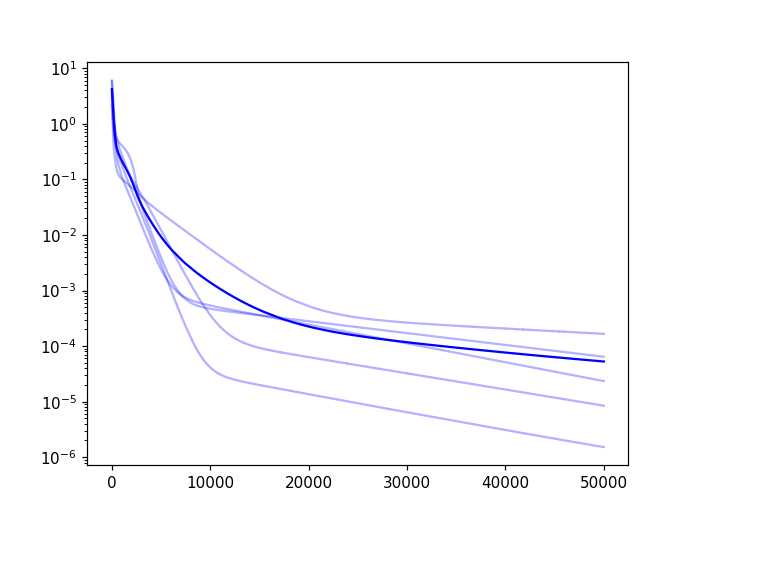

In [234]:
%matplotlib notebook
k_plots(poly_k_loss)

<IPython.core.display.Javascript object>


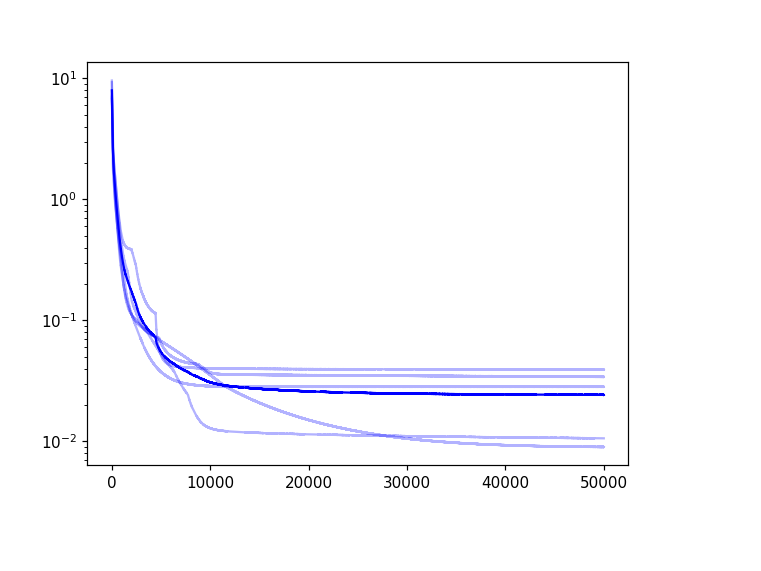

In [228]:
%matplotlib notebook
k_plots(relu_k_loss)

<IPython.core.display.Javascript object>


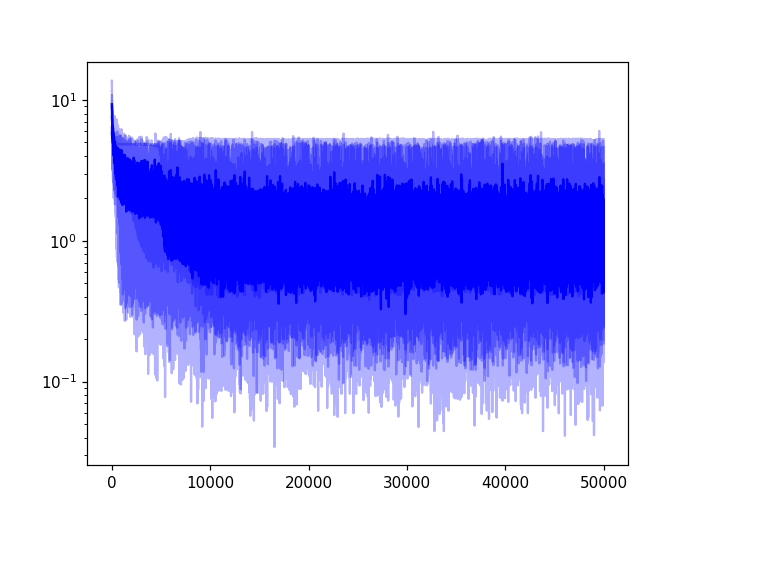

In [236]:
%matplotlib notebook
k_plots(relu_2_k_loss)

In [116]:
def k_plots(k_losses, c='blue'):
    assert len(k_losses) > 0
    plt.yscale('log')
    avgs = [0 for _ in k_losses[0]]
    for i, k in enumerate(k_losses):
        plt.plot(k, alpha=0.3, color=c)
        for j, ki in enumerate(k):
            avgs[j] += ki
    avgs = [x/len(k_losses) for x in avgs]
    plt.plot(avgs, color=c)
